# Importing Libraries

In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout

# EDA

## Reading the Data

In [2]:
data_dir = '/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv'

# parse_dates make date if like this 12/10/2010 to be like that 12-10-2010
# index_col to make col 'Date' is index

df = pd.read_csv(data_dir, index_col='Date', parse_dates=True)  

## Data Exploration

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


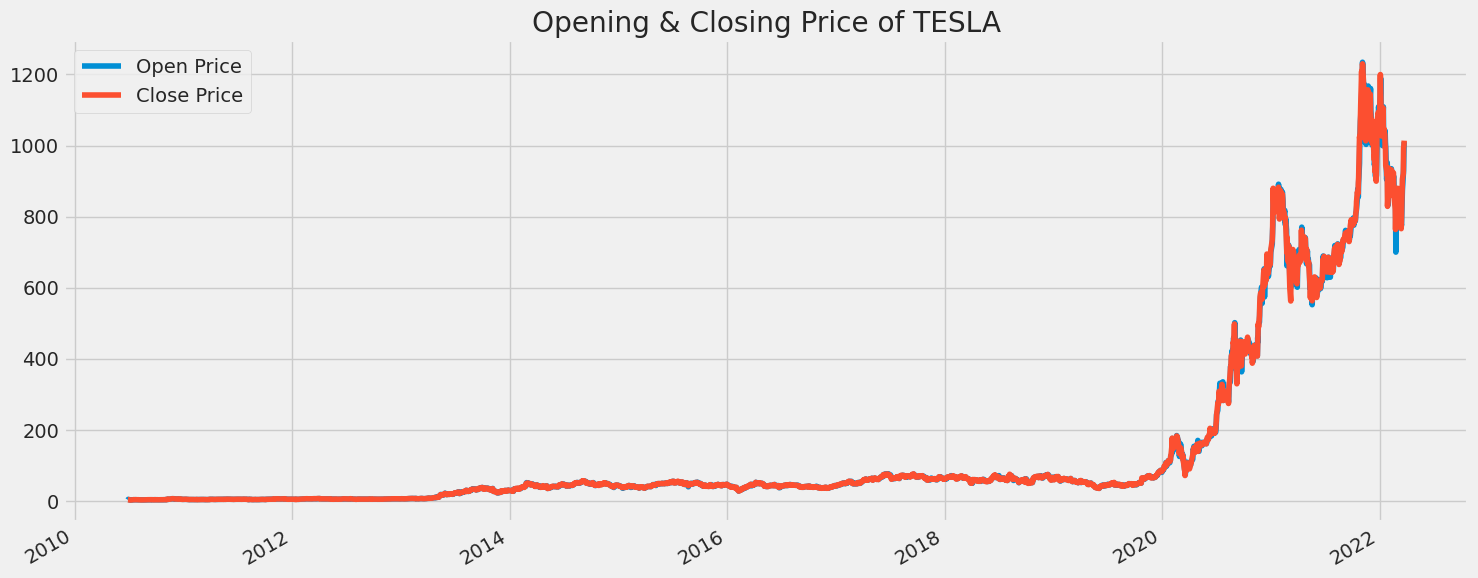

In [11]:
plt.figure(figsize=(15,6))
df['Open'].plot()
df['Close'].plot()
plt.xlabel(None)
plt.ylabel(None)
plt.title('Opening & Closing Price of TESLA')
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

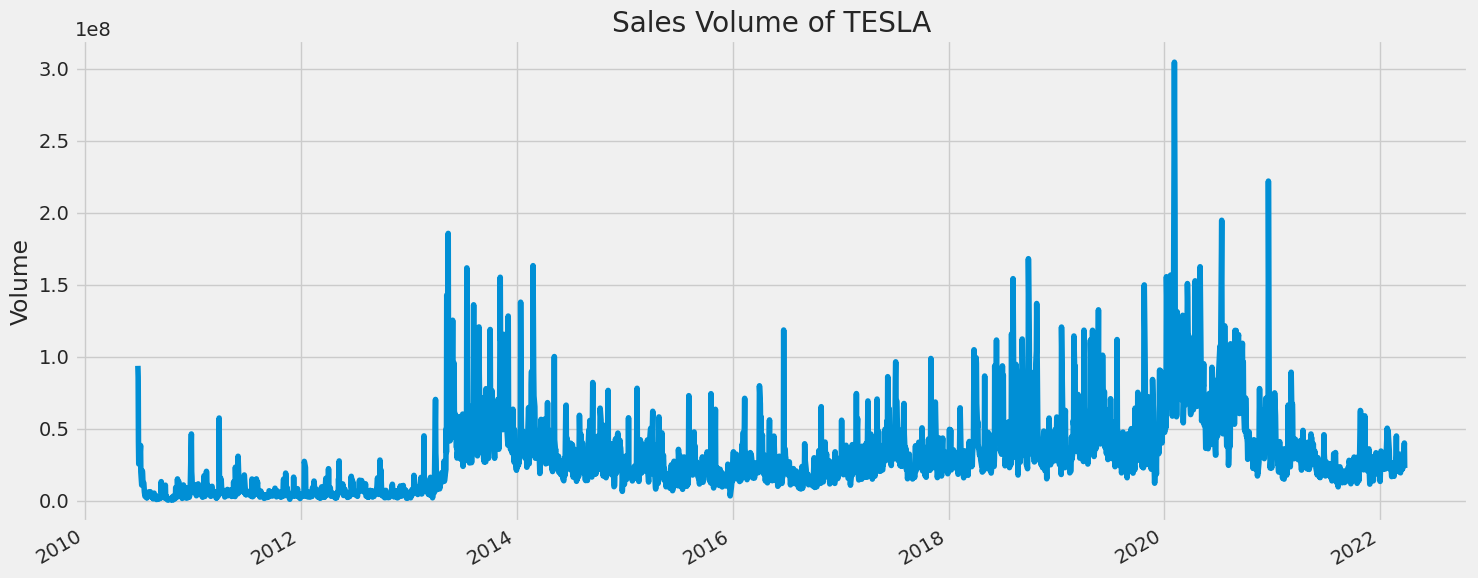

In [12]:
plt.figure(figsize=(15,6))
df['Volume'].plot()
plt.xlabel(None)
plt.ylabel('Volume')
plt.title('Sales Volume of TESLA')
plt.tight_layout()
plt.show()

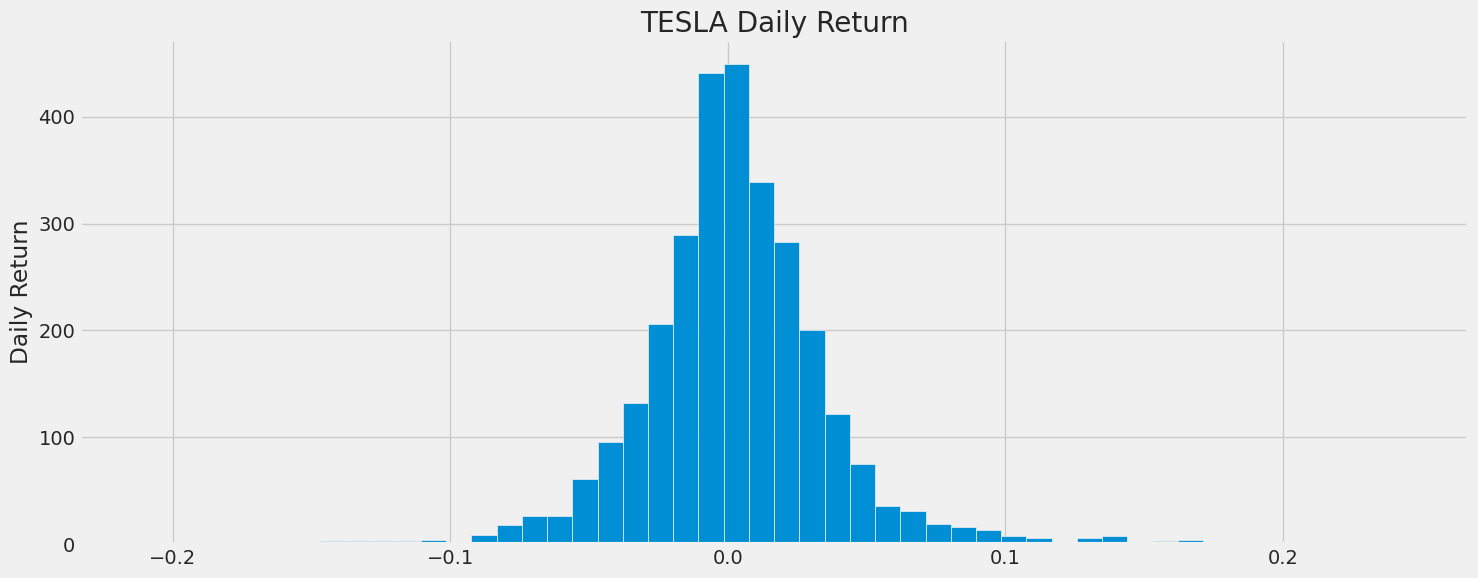

In [13]:
# we will use pct_change to find the percent change for each day
plt.figure(figsize=(15,6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'TESLA Daily Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

### Choosing Prediction Column

In [21]:
dataset = df['Close']
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(2956, 1)

In [27]:
dataset

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


### Normalizing Data

In [26]:
data

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [38]:
scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.80767879],
       [0.81186057],
       [0.82393312]])

### Splitting The Data

In [42]:
# 75% to Train, 25% to Test

# all len(data) = 2956
# I want 75% so len(data) * .75 = 2956 * .75 = 2217.0
# the type of result (len(data) * .75) will be 'float'
# I will convert to int so will write this code int(len(data) * .75) = 2217
train_size = int(len(data) * .75)     # 2217
test_size = len(data) - train_size    # 739      # same code int(len(data) * .25)   

print('Train Size : ', train_size, 'Test Size : ', test_size)

train_data = scaled_data[:train_size, 0:1]
test_data = scaled_data[train_size-60:, 0:1]

Train Size :  2217 Test Size :  739


In [44]:
print('Shape of Train Data : ', train_data.shape)
print('Shape of Test Data', test_data.shape)

Shape of Train Data :  (2217, 1)
Shape of Test Data (799, 1)


### Creating Training Set

In [45]:
# Creating a Training Set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60 : i , 0])
    y_train.append(train_data[i , 0])

In [49]:
# Convert to numpy array 
x_train, y_train = np.array(x_train) , np.array(y_train)

In [56]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [57]:
x_train

array([[[1.31893210e-03],
        [1.30915016e-03],
        [1.00427957e-03],
        ...,
        [8.57550414e-04],
        [8.10271019e-04],
        [6.63541861e-04]],

       [[1.30915016e-03],
        [1.00427957e-03],
        [5.54310154e-04],
        ...,
        [8.10271019e-04],
        [6.63541861e-04],
        [6.13001817e-04]],

       [[1.00427957e-03],
        [5.54310154e-04],
        [5.05400434e-05],
        ...,
        [6.63541861e-04],
        [6.13001817e-04],
        [7.01039312e-04]],

       ...,

       [[4.67022608e-02],
        [4.61577326e-02],
        [4.43105771e-02],
        ...,
        [4.11852428e-02],
        [4.10678619e-02],
        [4.08526591e-02]],

       [[4.61577326e-02],
        [4.43105771e-02],
        [4.49496609e-02],
        ...,
        [4.10678619e-02],
        [4.08526591e-02],
        [4.19906253e-02]],

       [[4.43105771e-02],
        [4.49496609e-02],
        [4.58512325e-02],
        ...,
        [4.08526591e-02],
        [4.1990

In [58]:
x_train.shape, y_train.shape

((2157, 60, 1), (2157,))

# LSTM Model

In [62]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [64]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [65]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 2.1918e-04 - mean_absolute_error: 0.0098
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.8773e-06 - mean_absolute_error: 0.0017
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.6756e-06 - mean_absolute_error: 0.0019
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.5333e-06 - mean_absolute_error: 0.0017
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.0487e-06 - mean_absolute_error: 0.0019
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.4483e-06 - mean_absolute_error: 0.0017
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.6595e-06 - mean_absolute_error: 0.0016
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 5.9997e-06 - mean_absolute_error: 0.0019
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6.4824e-06 - mean_absolute_error: 0.0020
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.0349e-06 - mean_absolute_err

## Model Evaluation

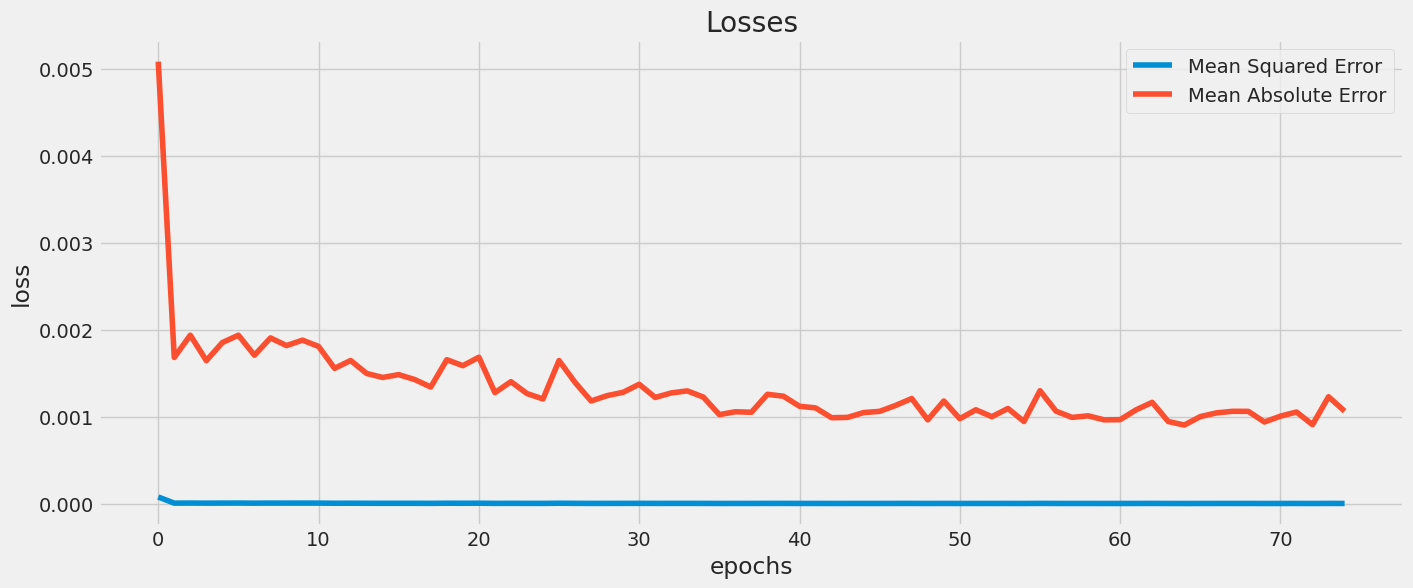

In [67]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Predection

### Creating testing set

In [69]:
# Creating a Testing Set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i,0])

In [70]:
x_test , y_test = np.array(x_test), np.array(y_test)

In [71]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [72]:
x_test.shape, y_test.shape

((739, 60, 1), (739,))

In [73]:
# inverse y_test scaling 
predictions = model.predict(x_test)

# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


(739, 1)

## Root mean squared error

In [80]:
# inverse y_test scaling 
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean(y_test - predictions)**2).round(2)
RMSE

30.01

## Visualize Predictions with the Data

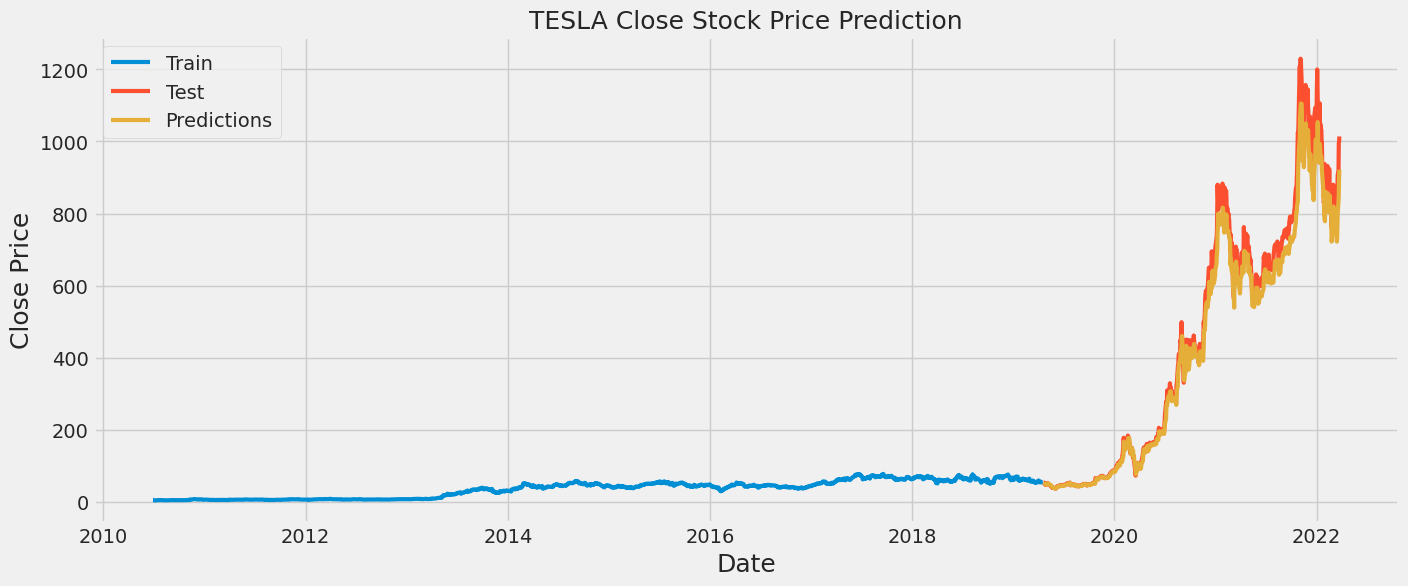

In [82]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize=(15,6))
plt.title('TESLA Close Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'], linewidth=3)
plt.plot(test['Close'], linewidth=3)
plt.plot(test['Predictions'], linewidth=3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 30 Days

In [83]:
from datetime import timedelta

In [84]:
def insert_end(Xin, new_input):
    timestep = 60 
    for i in range(timestep - 1):    # This loop for making shift to build new Xin
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep-1, :] = new_input
    return Xin

In [86]:
future = 30 
forecast = []
Xin = x_test[-1: , :, :]
time = []

for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forecast.append(out[0,0])
    print(forecast)
    Xin = insert_end(Xin, out[0,0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.71368337]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.71368337, 0.67001057]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.71368337, 0.67001057, 0.6252473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135, 0.5092701]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135, 0.5092701, 0.4796854]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135, 0.5092701, 0.4796854, 0.4545868]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135, 0.5092701, 0.4796854, 0.4545868, 0.4334387]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.71368337, 0.67001057, 0.6252473, 0.5825453, 0.5436135, 0.5092701, 0.4796854, 0.4545868, 0.433438

In [87]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

In [88]:
forecast

[0.71368337,
 0.67001057,
 0.6252473,
 0.5825453,
 0.5436135,
 0.5092701,
 0.4796854,
 0.4545868,
 0.4334387,
 0.41558674,
 0.40036088,
 0.38714463,
 0.37541124,
 0.36473972,
 0.3548134,
 0.34540948,
 0.33638334,
 0.32765055,
 0.31917036,
 0.31093034,
 0.3029348,
 0.2951955,
 0.287725,
 0.28053367,
 0.27362683,
 0.26700458,
 0.26066196,
 0.25458995,
 0.24877636,
 0.24320723]

## Create Forecasted Dataframe

In [96]:
forecasted_output = np.array(forecast)
forecasted_output = forecasted_output.reshape(-1,1)
forecasted_output = scaler.inverse_transform(forecasted_output)

In [99]:
forecasted_output = pd.DataFrame(forecasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date, forecasted_output], axis=1)
df_result.columns = 'Date', 'Forecasted'

## Forecasted TESLA close price

In [100]:
df_result

,Date,Forecasted
0,2022-03-24,878.671143
1,2022-03-25,825.095520
2,2022-03-26,770.182190
3,2022-03-27,717.797485
4,2022-03-28,670.037903
5,2022-03-29,627.907104
6,2022-03-30,591.614075
7,2022-03-31,560.824341
8,2022-04-01,534.880920
9,2022-04-02,512.981018


In [102]:
df_result.set_index('Date', inplace=True)

In [103]:
df_result

,Forecasted
Date,
2022-03-24,878.671143
2022-03-25,825.095520
2022-03-26,770.182190
2022-03-27,717.797485
2022-03-28,670.037903
2022-03-29,627.907104
2022-03-30,591.614075
2022-03-31,560.824341
2022-04-01,534.880920


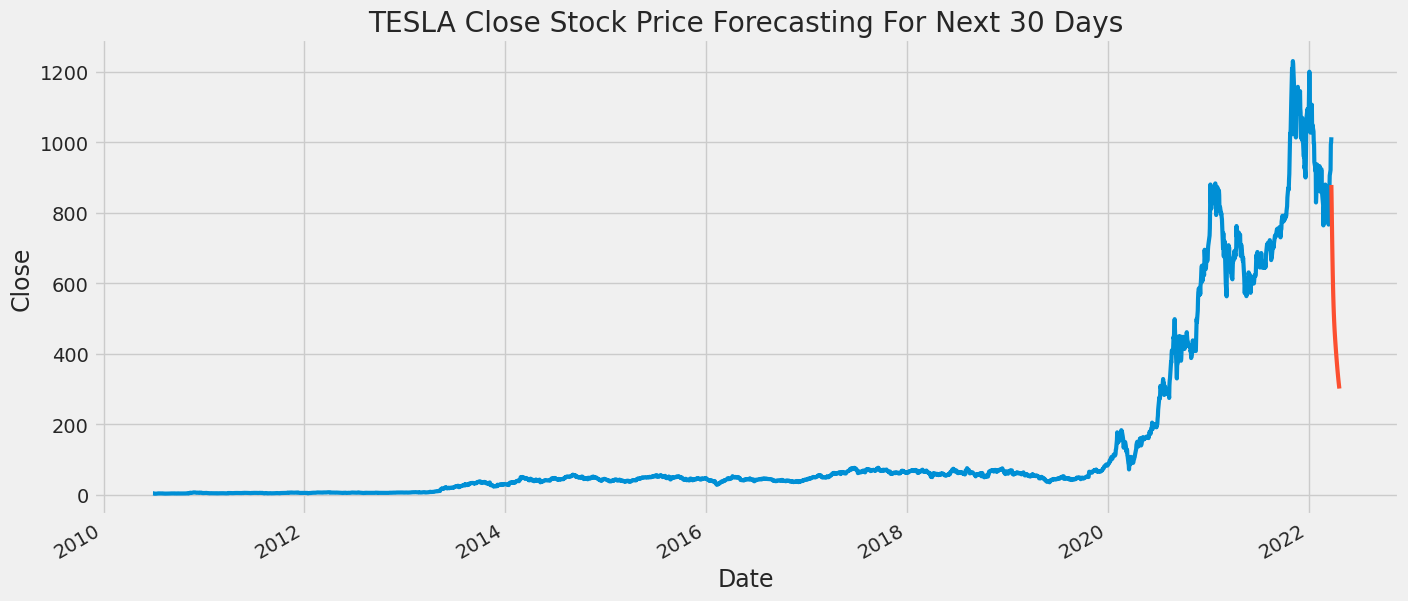

In [105]:
plt.figure(figsize=(15,7))
df['Close'].plot(linewidth=3)
df_result['Forecasted'].plot(linewidth=3)
plt.title('TESLA Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize = 17)
plt.ylabel('Close', fontsize = 17)
plt.show()